In [6]:
import matplotlib.pyplot as plt
import numpy as np
from qplotting import Qplotter
from qplotting.utils import set_size_pt
import seaborn as sns
cmap = sns.color_palette('deep', as_cmap=True)

In [2]:
def extract_fidelities(num_qubits):
    fids = {}
    for nq in num_qubits:
        path = f"data/svd_checks/{nq}/"
        singvals = [np.load(path+f"states_0.npy", allow_pickle=True)]

        for idx in range(1, 10):
            try:
                sv = np.load(path+f"states_{idx}.npy", allow_pickle=True)
                if sv.shape == singvals[0].shape:
                    singvals.append( sv )
            except:
                print(f"No file with index {idx} for {nq} qubits")
                break
        fidelities = []
        for sv in singvals:
            fid = np.cumprod( (1-sv)**2 )
            fidelities.append(fid)

        if len(fidelities) >1:
            mean_fid = np.mean(fidelities, axis=0)
            std_fid = np.std(fidelities, axis=0)
        else:
            mean_fid = fidelities
            std_fid = np.zeros_like(fidelities)

        fids[nq] = np.vstack((mean_fid, std_fid))

    return fids

In [3]:
num_qubits = [30, 50]
fids = extract_fidelities(num_qubits)

Fig dimension in pt: 234 144


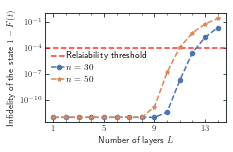

In [17]:
plotter = Qplotter()
#plotter(nrows=1, ncols=2, figsize=set_size_pt(2*234, subplots=(1, 2)) )
plotter(figsize=set_size_pt(234))

tt_30 = fids[30].shape[1]
tt_50 = fids[50].shape[1]
len_layer_30 = int( tt_30/14 )
len_layer_50 = int( tt_50/14 )

fid_30_per_layer = fids[30][0, np.arange(0, tt_30, len_layer_30)]
#[ np.prod( fids[30][0, :][ii*len_layer_30:(ii+1)*len_layer_30]) for ii in range(14) ]
fid_50_per_layer = fids[50][0, np.arange(0, tt_50, len_layer_50)]
#[ np.prod(fids[50][0, :][ii*len_layer_50:(ii+1)*len_layer_50]) for ii in range(14) ]
layers = np.arange(1, 15)

bonddim = [2**ii for ii in range(13)]
entanglement = np.loadtxt("data/svd_checks/50/layer9_ent.npy")
entanglement = np.max(entanglement, axis=1)
relative_ent_err = np.abs(entanglement - entanglement[-1] )/entanglement[-1]

with plotter as qplt:
    qplt.ax.axhline(1e-4, color="red", ls='--', alpha=0.8, label="Relaiability threshold")
    qplt.ax.plot(layers, 1-fid_30_per_layer+1e-12, 'o--', label="$n=30$", color=cmap[0])
    qplt.ax.plot(layers, 1-fid_50_per_layer+1e-12, '*--', label="$n=50$", color=cmap[1])
    qplt.ax.set_yscale("log")
    qplt.ax.set_xticks(np.arange(1, 15, 4))
    #qplt.set_ylim(1e-13, 100)
    #qplt.ax[0].vlines(len_layer*13, mean_fid[len_layer*13]-0.005, mean_fid[len_layer*13]+0.005, label="layer", color="red")

    qplt.ax.set_xlabel("Number of layers $L$")
    qplt.ax.set_ylabel("Infidelity of the state $1-F(t)$")
    qplt.ax.legend(frameon=False, loc="center left")

    #qplt.ax[1].plot(bonddim, relative_ent_err[:13], 'o--', label="$L=9$", color=cmap[2])
    #qplt.ax[1].set_ylabel("Relative entanglement error")
    #qplt.ax[1].set_xlabel("Maximum bond dimension $\chi_s$")
    #qplt.ax[1].set_xscale("log", base=2)
    #qplt.ax[1].set_yscale("log")
    #qplt.ax[1].legend(frameon=False)

    qplt.savefig("images/covergence.pdf")

# Time difference between exact and MPS

In [177]:
times_aer = np.loadtxt("data/marcos_plot/alternate_abbas16_Aer_time.npy")
times_mps = np.loadtxt("data/marcos_plot/alternate_abbas16_MPS_time.npy")

Fig dimension in pt: 234 144


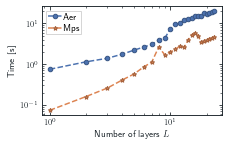

In [179]:
layers = np.arange(1, len(times_aer)+1)

with Qplotter() as qplt:
    qplt.plot(layers, (times_aer), 'o--', label="Aer", color=cmap[0])
    qplt.plot(layers, (times_mps), '*--', label="Mps", color=cmap[1])

    qplt.set_xscale("log")
    qplt.set_yscale("log")
    qplt.set_ylabel("Time [s]")
    qplt.set_xlabel("Number of layers $L$")
    qplt.legend()

    qplt.savefig("images/Exact_MPS_comparison.pdf")

# Marchenko pastur distribution

In [7]:
from marchenko_pastur import gen_mp

def kl_div(prob_p, prob_q, dp):
    prob_p += 1e-12
    prob_q += 1e-12
    return  prob_p*np.log(prob_p/prob_q)*dp


def get_mp_distributions(num_qub, max_num_layers, filename):
    bonddim = 2**(num_qub//2)
    bins = np.logspace(-5, -1.5, 50)
    num_layers = np.arange(1, max_num_layers)
    results = {
        "bins" : bins,
        "layers" : num_layers,
        "num_qubits" : num_qub,
        "xx" : (bins[1:]+ bins[:-1])/2,
        "dp" : (bins[1:]- bins[:-1]),
    }

    # Marchenko-pastur distributed
    l1 = num_qub//2
    l2 = num_qub//2 if num_qub%2 == 0 else num_qub//2+1
    sigma = np.sqrt(1.0 / 2**(max(l1, l2)))
    sampled_singvals = np.array([])
    for _ in range(1000):
        s_singvals = gen_mp(2**l2, 2**l1, sigma, bonddim, bonddim)
        s_singvals /= np.sqrt( np.sum(s_singvals**2) )
        sampled_singvals = np.append(sampled_singvals, s_singvals)
    mp_hist, _ = np.histogram(sampled_singvals**2, bins, density=True)
    results["mp"] = mp_hist
    results["cmp"] = np.cumsum(mp_hist)/np.sum(mp_hist)

    # From Haar-random state
    random_state_singvals = np.array([])
    for _ in range(100):
        psi = np.random.normal(0, sigma, 2**num_qub) + 1j*np.random.normal(0, sigma, 2**num_qub)
        psi /= np.sqrt( np.sum( np.abs(psi)**2 ) )
        rn_ss = np.linalg.svd(psi.reshape(2**l1, 2**l2), False, False)
        rn_ss /= np.sqrt( np.sum(rn_ss**2) )
        random_state_singvals = np.hstack( (random_state_singvals, rn_ss))
    rn_hist, _ = np.histogram(random_state_singvals**2, bins, density=True)
    results["random"] = rn_hist
    results["crandom"] = np.cumsum(rn_hist)/np.sum(rn_hist)

    # Experimental
    exp_hists = []
    exp_cum = []
    for nl in num_layers:
        singvals = []
        for ss in np.load(filename + f"{num_qub}_{nl}.npy", allow_pickle=True):
            singvals = np.hstack((singvals, ss))

        exp_hist, _ = np.histogram(singvals**2, bins, density=True)
        exp_hists.append(exp_hist)
        exp_cum.append( np.cumsum(exp_hist)/np.sum(exp_hist) )
    results["exp"] = exp_hists
    results["cexp"] = exp_cum

    return results

def plot_mp_results(fig, ax, results):

    mask = results["mp"] > 1e-10
    ax[0].plot(results["xx"][mask], results["cmp"][mask], lw=5, label="MP")

    mask = results["random"] > 1e-10
    ax[0].plot(results["xx"][mask], results["crandom"][mask], '--', lw=2, color="black", label="RAND")

    layers_to_plot = np.linspace( np.max(results["layers"])//3, np.max(results["layers"]), 4 )
    layers_to_plot = np.unique( layers_to_plot.astype(int) )

    kl_divergences = []
    for idx, nl in enumerate(results["layers"]):
        exp_hist = results["exp"][idx]
        kl = kl_div(results["mp"], exp_hist, results["dp"])
        kl_divergences.append(np.sum(kl) )

        if nl in layers_to_plot:
            mask = exp_hist > 1e-10
            ax[0].plot(results["xx"][mask], results["cexp"][idx][mask], '.-', label="$L=$"+str(nl), alpha=0.5 )

    ax[0].legend()
    ax[0].set_yscale("log")
    ax[0].set_xscale("log")
    ax[0].set_ylabel("Cumulative probability")
    ax[0].set_xlabel("Singular values squared")


    kl_div_good = np.sum( kl_div(results["mp"], results["random"], results["dp"]) )
    # Parameters of the variational ansatz + parameters of the feature map

    ax[1].axhline(kl_div_good, ls='--', color="black", label="Best value")
    #ax[1].axvline(2**num_qub, ls='--', color="red", label="Best value")
    ax[1].plot(results["layers"], kl_divergences, 'o', label="Experimental value")
    ax[1].set_yscale("log")
    #ax[1].set_xscale("log")
    ax[1].set_ylabel("KL divergence between experimental and MP distribution")
    ax[1].set_xlabel("Number of layers")
    ax[1].legend()

def plot_mp_distribution(fig, ax, results):

    mask = results["mp"] > 1e-10
    ax.plot(results["xx"][mask], results["cmp"][mask], lw=3, label="MP")

    mask = results["random"] > 1e-10
    ax.plot(results["xx"][mask], results["crandom"][mask], '--', lw=1.5, color="black", label="Haar")

    layers_to_plot = [6, 10, 15]

    kl_divergences = []
    for idx, nl in enumerate(results["layers"]):
        exp_hist = results["exp"][idx]
        kl = kl_div(results["mp"], exp_hist, results["dp"])
        kl_divergences.append(np.sum(kl) )

        if nl in layers_to_plot:
            mask = exp_hist > 1e-10
            ax.plot(results["xx"][mask], results["cexp"][idx][mask], '.-', label="$L=$"+str(nl), alpha=0.8 )

    ax.legend(frameon=False, handletextpad=0.4)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("CDF $C(\lambda^2)$")
    ax.set_xlabel("Singular values squared $\lambda^2$")
    ax.set_ylim(10**(-2.1), 1.5)

In [8]:
filename = "data/marchenko-pastur/singvals"
num_qub = 15
max_nl = 20

results15_zzc2 = get_mp_distributions(num_qub, max_nl, filename)

filename = "data/marchenko-pastur/singvals_c2c2_"
num_qub = 15
max_nl = 16

results15_c2c2 = get_mp_distributions(num_qub, max_nl, filename)

Fig dimension in pt: 234 144


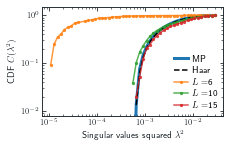

In [9]:
with Qplotter() as qplt:
    plot_mp_distribution(qplt.fig, qplt.ax, results15_zzc2)

    qplt.savefig("images/mp_convergence.pdf")